# Machine Learning - Project - Group MAA_202021_10
## Group Members
|Name|StudentID|
|:-----------:|:--------:|
|Fabio Lopes|20200597|
|Filipe Costa|20201041|
|Jorge Pereira|20201085|


## Package Instalation and Importing

In [1]:
import sys
#!{sys.executable} -m pip install -U xlrd
#!{sys.executable} -m pip install -U xgboost
#!{sys.executable} -m pip install -U hyperopt
#!{sys.executable} -m pip install -U mlflow
#!{sys.executable} -m pip install -U imbalanced-learn
#!{sys.executable} -m pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
#!{sys.executable} -m pip install -U mlxtend

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import time

from sklearn.model_selection import train_test_split, cross_val_score,cross_validate,GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, auc, classification_report,confusion_matrix,plot_roc_curve,precision_recall_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import precision_score
from imblearn.over_sampling import SMOTE, ADASYN,RandomOverSampler
from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler, NearMiss

import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import Counter
from matplotlib import pyplot

In [3]:
def print_df(df):
    return df.style.hide_index().set_properties(**{
    'font-size': '11pt','border': '1pt solid'
    })

In [4]:
data = pd.read_excel('Train.xlsx')
data_test = pd.read_excel("Test.xlsx")

In [5]:
print(f"Training data has {data.shape[1]} columns and {data.shape[0]} rows.")

Training data has 15 columns and 22400 rows.


In [6]:
data.head(5)

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


In [7]:
missing_values_columns = []
for column in data.columns:
    if '?' in data[column].values:
        total = len(data[data[column].str.contains('\?')])
        missing_values_columns.append({'Column': column, 'Total': total})
    if len(data[data[column].isna()]) > 0:
        total = len(data[data[column].isna()])
        missing_values_columns.append({'Column': column, 'Total': total})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
df_missing_values = pd.DataFrame(missing_values_columns)
df_missing_values = df_missing_values.style.set_properties(**{'text-align': 'left'}).set_table_styles([ dict(selector='th', props=[('text-align', 'left')] ) ])
df_missing_values = df_missing_values.hide_index()
df_missing_values.set_properties(**{
    'font-size': '11pt','border': '1pt solid'
})

Column,Total
Base Area,395
Employment Sector,1264
Role,1271


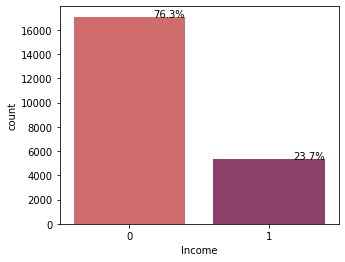

In [9]:
plt.figure(figsize=(5,4))
total = float(len(data))
ax = sns.countplot(x="Income", data=data, color="c",palette='flare')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')

## Data Cleansing & Feature Engineering Functions
In this section, we will define the Cleansing functions

In [10]:
def strip_lower(df):
    """Detects the String columns and converts all the records to lowercase."""
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(str.strip).apply(str.lower)
    return df

In [11]:
def fill_missing_values(df,ColumnswithMissingValues):
    for column in ColumnswithMissingValues:
        ColumnMode = df[column].mode()[0]
        df[column] = df[column].str.replace('?',ColumnMode, regex=False)
    return df

In [12]:
def ComputeAgeAt2048(Birthday):
    CurrentYear=datetime(2048,1,1)
    
    s_YearOfBirth = Birthday.split(",")[1]
    YearOfBirth = datetime(int(s_YearOfBirth),1,1)
        
    return CurrentYear.year - YearOfBirth.year

In [13]:
def ClassifyCitizen(Difference):
    if Difference == 0:
        return 'A' # Chosen carefully from volunteers
    elif Difference > 0:
        return 'B' # Invited
    elif Difference < 0:
        return 'C' # Paid

In [14]:
def encode_data(data, nominal_variables):
    data_Encoded = data.copy()
    dummies = pd.get_dummies(data_Encoded[nominal_variables], prefix=nominal_variables)
    data_Encoded = pd.concat([data_Encoded,dummies],axis=1)
    data_Encoded = data_Encoded.drop(nominal_variables, axis =1)
    return data_Encoded

In [15]:
def AlignDataframe(ColumnsInModel,df):
    dummy_df = pd.DataFrame(columns=ColumnsInModel)
    dummy_df, aligned_df = dummy_df.align(df,fill_value=0,join='left',axis=1)
    return aligned_df

In [16]:
def MaritalStatusNormalization(Mstatus):
    if Mstatus == 'married':
        return 'married'
    elif Mstatus == 'single':
        return 'not_married'
    elif Mstatus == 'divorced':
        return 'not_married'
    elif Mstatus == 'separated':
        return 'not_married'
    elif Mstatus == 'widow':
        return 'not_married'
    elif Mstatus == 'married - spouse missing':
        return 'married'
    elif Mstatus == 'married - spouse in the army':
        return 'married'
    else:
        return 'NA'

In [17]:
def LivesWithNormalization(Lwith):
    if Lwith == 'wife':
        return 'spouse'
    elif Lwith == 'other family':
        return 'other'
    elif Lwith == 'children':
        return 'children'
    elif Lwith == 'alone':
        return 'alone'
    elif Lwith == 'husband':
        return 'spouse'
    elif Lwith == 'other relatives':
        return 'other'
    else:
        return 'NA'

In [18]:
def Sector(S):
    if S == 'private sector - services':
        return 'private'
    elif S == 'self-employed (individual)':
        return 'self'
    elif S == 'public sector - others':
        return 'public'
    elif S == 'private sector - others':
        return 'private'
    elif S == 'self-employed (company)':
        return 'self'
    elif S == 'public sector - government':
        return 'public'
    elif S == 'unemployed':
        return 'None'
    elif S == 'never worked':
        return 'None'
    else:
        return 'NA'

In [19]:
def DataPreProcessing(data):
    # Lowers all case in string variables
    new_df = data.copy()

    new_df = strip_lower(new_df)

    # Deals with missing values
    ColumnswithMissingValues = ['Role','Employment Sector','Base Area']
    new_df = fill_missing_values(new_df,ColumnswithMissingValues)

    # Computes Age
    new_df['Age'] = new_df['Birthday'].apply(ComputeAgeAt2048)
    new_df.drop('Birthday', axis=1, inplace=True)

    # Classifies Citizen
    new_df['Group'] = (new_df['Money Received'] - new_df['Ticket Price']).apply(ClassifyCitizen)

    # Marital Status Normalization
    new_df['MStatus'] = new_df['Marital Status'].apply(MaritalStatusNormalization)
    new_df.drop('Marital Status', axis=1, inplace=True)

    # Lives With Normalization
    new_df['Lwith'] = new_df['Lives with'].apply(LivesWithNormalization)
    new_df.drop('Lives with', axis=1, inplace=True)

    # Employment Sector Normalization
    new_df['Sector'] = new_df['Employment Sector'].apply(Sector)
    new_df.drop('Employment Sector', axis=1, inplace=True)

    # Creates Ordinal Variable from Education
    EducationClassification = {
                            "phd" : 16,
                            "masters + postgraduation" : 15,
                            "masters" : 14,
                            "bachelors + postgraduation" : 13,
                            "bachelors" : 12,
                            "professional school + postgraduation" : 11,
                            "high school + postgraduation" : 10,
                            "professional school" : 9,
                            "high school complete" : 8,
                            "high school - 2nd cycle" : 7,
                            "high school - 1st cycle" : 6,
                            "middle school complete" : 5,
                            "middle school - 2nd cycle" : 4,
                            "middle school - 1st cycle" : 3,
                            "primary school" : 2,
                            "preschool" : 1
                            }
    new_df['Education_Class'] = new_df['Education Level'].map(EducationClassification)
    new_df.drop('Education Level', axis=1, inplace=True)

    # Performs one hot encoding in nominal variables
    NominalVariables = ['Native Continent', 
                        'Role', 
                        'MStatus', 
                        'Lwith', 
                        'Sector', 
                        'Group']

    new_df = encode_data(new_df, NominalVariables)

    # Drops the Name column and selects Citizen ID as the index
    new_df = new_df.drop(['Name'], axis =1)
    new_df = new_df.drop(['Base Area'], axis =1)
    new_df.set_index(["CITIZEN_ID"],inplace=True)


    return new_df.copy()

In [20]:
processedTrainingData = DataPreProcessing(data)
processedTestingData = DataPreProcessing(data_test)

In [21]:
processedTrainingData.head(5)

,Years of Education,Working Hours per week,Money Received,Ticket Price,Income,Age,Education_Class,Native Continent_africa,Native Continent_america,Native Continent_asia,...,Lwith_children,Lwith_other,Lwith_spouse,Sector_None,Sector_private,Sector_public,Sector_self,Group_A,Group_B,Group_C
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,13,40,0,2273,1,45,10,0,0,0,...,0,0,1,0,1,0,0,0,0,1
12487,12,40,0,0,1,42,9,0,0,0,...,0,0,1,0,0,1,0,1,0,0
12488,12,46,0,2321,1,39,9,0,0,0,...,0,0,1,0,1,0,0,0,0,1
12489,11,37,5395,0,1,63,7,0,0,0,...,0,0,1,0,1,0,0,0,1,0
12490,21,45,0,0,1,33,16,0,0,0,...,0,1,0,0,0,0,1,1,0,0


In [22]:
metadata = pd.DataFrame(columns=['Name','Description'])
metadata = metadata.append({'Name': 'Age', 'Description': 'Calculated using the Birthday column'},ignore_index=True)
metadata = metadata.append({'Name': 'Group', 'Description': 'Using the Ticket Price and Money Received columns'},ignore_index=True)
metadata = metadata.append({'Name': 'MStatus', 'Description': 'Binary column to indicates if the candidate is married or not. '},ignore_index=True)
metadata = metadata.append({'Name': 'LWith', 'Description': 'Indicates if the candidate lives alone, with spouse, children or with other relatives'},ignore_index=True)

In [23]:
new_columns = ['Age','Group','MStatus','LWith']
metadata = metadata[metadata['Name'].isin(new_columns)]
metadata.style.hide_index()
metadata = metadata.style.hide_index()
metadata.set_properties(**{
    'font-size': '11pt','border': '1pt solid'
})

Name,Description
Age,Calculated using the Birthday column
Group,Using the Ticket Price and Money Received columns
MStatus,Binary column to indicates if the candidate is married or not.
LWith,"Indicates if the candidate lives alone, with spouse, children or with other relatives"


## Model Creation
In this section, we will create the models.

In [24]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
def runModels(models,X,y,X_test,y_test):

    GlobalTimerStart = time.time()
    ModelPerf = []
    for model in models:
        print(f"Running Model: {type(model).__name__}")
        LocalTimerStart = time.time()
        clf = LogisticRegression(solver="liblinear", random_state=0).fit(X, y)
        model.fit(X,y)
        scoresf1w = cross_validate(model, X,y, cv=10,scoring=('f1_micro'))
        
        labels_train = model.predict(X)        
        labels_val = model.predict(X_test)
        
        print(confusion_matrix(y_test, labels_val))
        
        train_precision = precision_score(y, labels_train, average='micro')
        test_precision = precision_score(y_test, labels_val, average='micro')
        
        train_recall = recall_score(y, labels_train, average='micro')
        test_recall = recall_score(y_test, labels_val, average='micro')
        
        roc_auc_train = roc_auc_score(y, labels_train, average='micro')
        roc_auc_test = roc_auc_score(y_test, labels_val, average='micro')
        
        
        ModelPerf.append((type(model).__name__,
                          'Train',
                          scoresf1w['test_score'].mean(),
                          train_precision,
                          train_recall,
                          roc_auc_train
        ))
        ModelPerf.append((type(model).__name__,
          'Test',
          f1_score(y_test, labels_val, average='micro'),
          test_precision,
          test_recall,
          roc_auc_test
        ))
        
        LocalTimerEnd = time.time()
        print(f"-- Done. Duration: {LocalTimerEnd-LocalTimerStart} s")
    GlobalTimerEnd = time.time()
    print(f"GLOBAL DURATION: {GlobalTimerEnd-GlobalTimerStart} s")
    
    res = pd.DataFrame(ModelPerf,columns=['model','Stage','f1_micro', 'precision_micro', 'recall_micro','roc_auc_micro'])
    
    
    fig = plt.figure(figsize=(20, 10))
    graph = sns.barplot(x="model", y="f1_micro", hue="Stage", data=res, palette='flare')
    graph.legend(loc='lower left')
    for bar in graph.patches:
        graph.annotate(format(bar.get_height(), '.4f'), 
                       (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -12),
                       color="white",
                       textcoords = 'offset points')

    graph.set_xticklabels(graph.get_xticklabels(),
                          rotation=45,
                          horizontalalignment='center',
                          fontweight='light')
    
    return res, models

In [25]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax,cmap='flare')
    #plt.savefig(filename)
    plt.show()

In [26]:
def plot_roc_auc(model,testX, testy):
    ns_probs = [0 for _ in range(len(testy))]
    # predict probabilities
    lr_probs = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(type(model).__name__,' : ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label=type(model).__name__)
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [27]:
def plot_precision_recall(model,testX,testy):
    # predict probabilities
    lr_probs = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = model.predict(testX)
    lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
    lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
    # summarize scores
    print(type(model).__name__,' : f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(testy[testy==1]) / len(testy)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(lr_recall, lr_precision, marker='.', label=type(model).__name__)
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

### Correlation

In [28]:
corr_df = processedTrainingData[['Ticket Price','Working Hours per week', 'Money Received','Years of Education','Income', 'Age', 'Education_Class','Group_A', 'Group_B', 'Group_C']].corr()


<AxesSubplot:>

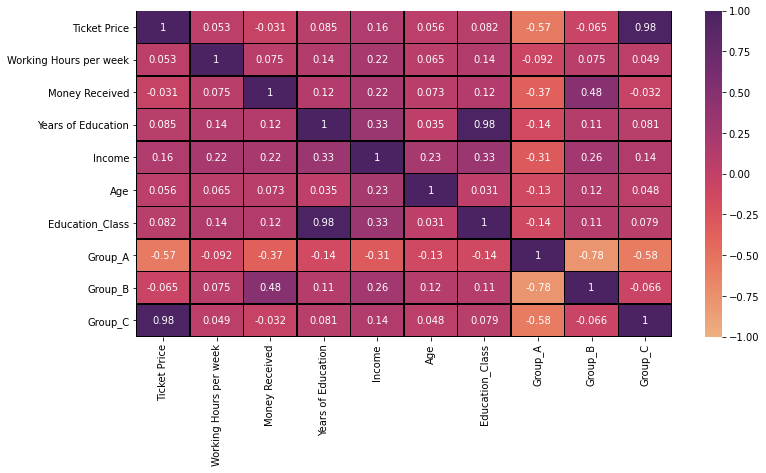

In [29]:
plt.figure(figsize=(12, 6))
sns.heatmap(corr_df, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'flare', linewidths=0.5, linecolor='black')

In [30]:
#High correlation between Ticket Price and Group_C. We can remove one of then
#Also high correlation between Years of Education and Education class
processedTrainingData = processedTrainingData.drop(['Group_C','Education_Class'],axis=1)

In [31]:
corr_df = processedTrainingData.corr()['Income']
low_corr_cols =[]
for col in list(corr_df.index):
    if(np.abs(corr_df[col]) < 0.1):
        low_corr_cols.append(col)

In [32]:
print(low_corr_cols)
processedTrainingData = processedTrainingData.drop(low_corr_cols,axis=1)

['Native Continent_africa', 'Native Continent_america', 'Native Continent_asia', 'Native Continent_europe', 'Native Continent_oceania', 'Role_administratives', 'Role_agriculture and fishing', 'Role_army', 'Role_cleaners & handlers', 'Role_household services', 'Role_it', 'Role_machine operators & inspectors', 'Role_repair & constructions', 'Role_sales', 'Role_security', 'Role_transports', 'Sector_None', 'Sector_public']


### Outliers

In [33]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05)
yhat = iso.fit_predict(processedTrainingData)
mask = yhat != -1

In [34]:
metrics_df = processedTrainingData.copy()
#specify the 12 metrics column names to be modelled
to_model_columns=[x for x in processedTrainingData.columns if x != 'Income']
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.05), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(metrics_df[to_model_columns])
pred = clf.predict(metrics_df[to_model_columns])
metrics_df['anomaly']=pred
metrics_df = metrics_df.reset_index()
outliers=metrics_df.loc[metrics_df['anomaly']==-1]
outlier_index=list(outliers.index)
print(metrics_df['anomaly'].value_counts())

 1    21280
-1     1120
Name: anomaly, dtype: int64


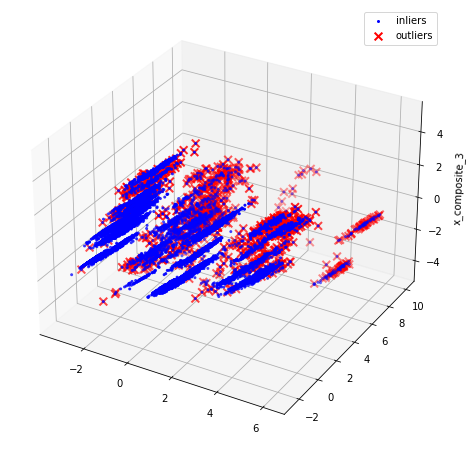

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(metrics_df[to_model_columns])
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="blue")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [36]:
yhat = clf.fit_predict(processedTrainingData)
mask = yhat != -1
processedTrainingData = processedTrainingData[mask]

### Split Training Data

In [37]:
target = 'Income'

X = processedTrainingData[[x for x in processedTrainingData.columns if x != target]]
y = processedTrainingData[[x for x in processedTrainingData.columns if x == target]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [38]:
# Backup the Source datasets
X_train_source = X_train.copy()
X_test_source = X_test.copy()
y_train_source = y_train.copy()
y_test_source = y_test.copy()

# MODEL DEFINITION

In [39]:
modellog = LogisticRegression(max_iter=1000000)
modelKNN = KNeighborsClassifier()
modelTree = DecisionTreeClassifier()
modelSVC = SVC()
modelNAB = GaussianNB()
modelRF = RandomForestClassifier()
modelGBC = GradientBoostingClassifier()
modelAda = AdaBoostClassifier()
modelLDA = LinearDiscriminantAnalysis()
modelBagging = BaggingClassifier()

# Run All Models, without over/under sampling and without scaling

Running Model: LogisticRegression
[[4741  270]
 [ 689  684]]
-- Done. Duration: 37.30323505401611 s
Running Model: KNeighborsClassifier
[[4612  399]
 [ 603  770]]
-- Done. Duration: 8.233445167541504 s
Running Model: DecisionTreeClassifier
[[4479  532]
 [ 660  713]]
-- Done. Duration: 0.7133183479309082 s
Running Model: SVC
[[4956   55]
 [1174  199]]
-- Done. Duration: 49.787835121154785 s
Running Model: GaussianNB
[[3458 1553]
 [ 166 1207]]
-- Done. Duration: 0.2836730480194092 s
Running Model: RandomForestClassifier
[[4616  395]
 [ 630  743]]
-- Done. Duration: 13.89859390258789 s
Running Model: GradientBoostingClassifier
[[4757  254]
 [ 641  732]]
-- Done. Duration: 11.192389726638794 s
Running Model: AdaBoostClassifier
[[4736  275]
 [ 635  738]]
-- Done. Duration: 4.852236986160278 s
Running Model: LinearDiscriminantAnalysis
[[4721  290]
 [ 663  710]]
-- Done. Duration: 0.7942743301391602 s
Running Model: BaggingClassifier
[[4582  429]
 [ 644  729]]
-- Done. Duration: 3.08347225189

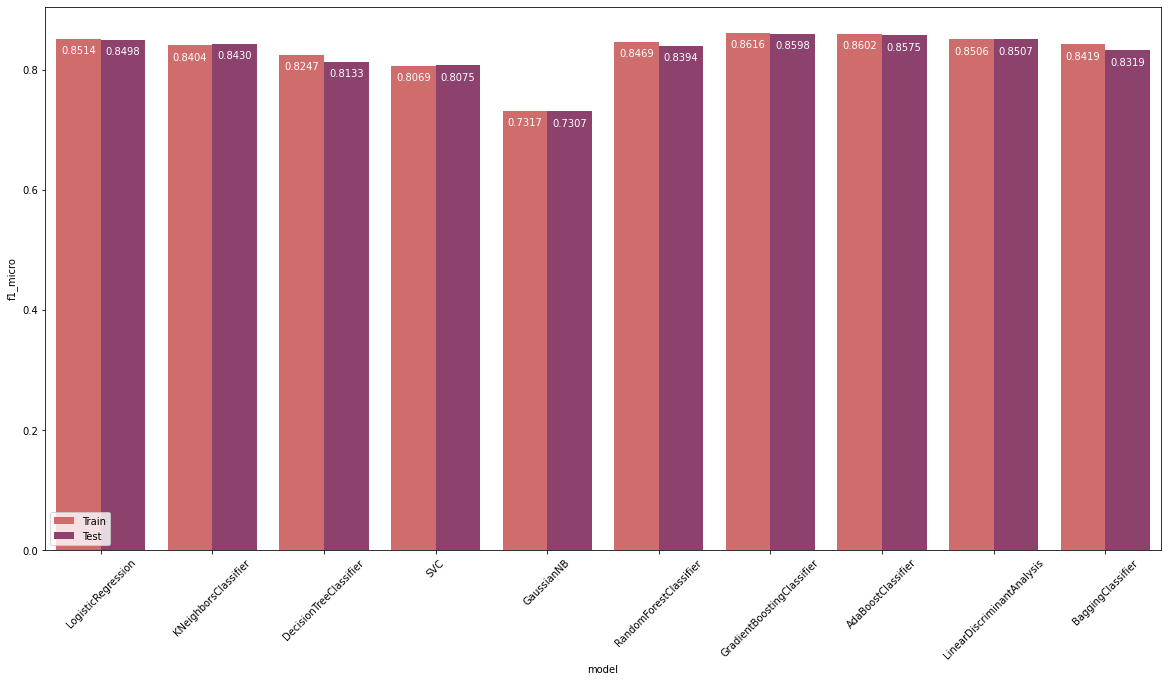

In [40]:
models = [  modellog,
            modelKNN,
            modelTree,
            modelSVC,
            modelNAB,
            modelRF,
            modelGBC,
            modelAda,
            #modelMLP, Too slow, will only put it there in the final version
            modelLDA,
            modelBagging]

DEFAULT_res, trained_models = runModels(models,X_train,y_train,X_test,y_test)

In [41]:
print_df(DEFAULT_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.851369,0.852645,0.852645,0.730839
LogisticRegression,Test,0.849781,0.849781,0.849781,0.722149
KNeighborsClassifier,Train,0.840359,0.883056,0.883056,0.797947
KNeighborsClassifier,Test,0.843045,0.843045,0.843045,0.740595
DecisionTreeClassifier,Train,0.824650,0.953276,0.953276,0.902657
DecisionTreeClassifier,Test,0.813283,0.813283,0.813283,0.706567
SVC,Train,0.806928,0.806995,0.806995,0.567391
SVC,Test,0.807487,0.807487,0.807487,0.566981
GaussianNB,Train,0.731671,0.731673,0.731673,0.788165
GaussianNB,Test,0.730733,0.730733,0.730733,0.784589


## Rebalance Dataset

In [42]:
counter = Counter(y_train)
print(counter)

Counter({0: 11694, 1: 3202})


### Using SMOTE to rebalance dataset

In [43]:
oversample = SMOTE(sampling_strategy=0.4)
SMOTE_X_train, SMOTE_y_train = oversample.fit_resample(X_train, y_train)
counter = Counter(SMOTE_y_train)
print(counter)

Counter({0: 11694, 1: 4677})


Running Model: LogisticRegression
[[4582  429]
 [ 564  809]]
-- Done. Duration: 44.649770975112915 s
Running Model: RandomForestClassifier
[[4511  500]
 [ 577  796]]
-- Done. Duration: 13.857083320617676 s
Running Model: GradientBoostingClassifier
[[4589  422]
 [ 470  903]]
-- Done. Duration: 13.852916717529297 s
Running Model: AdaBoostClassifier
[[4561  450]
 [ 471  902]]
-- Done. Duration: 6.2000038623809814 s
GLOBAL DURATION: 78.55977487564087 s


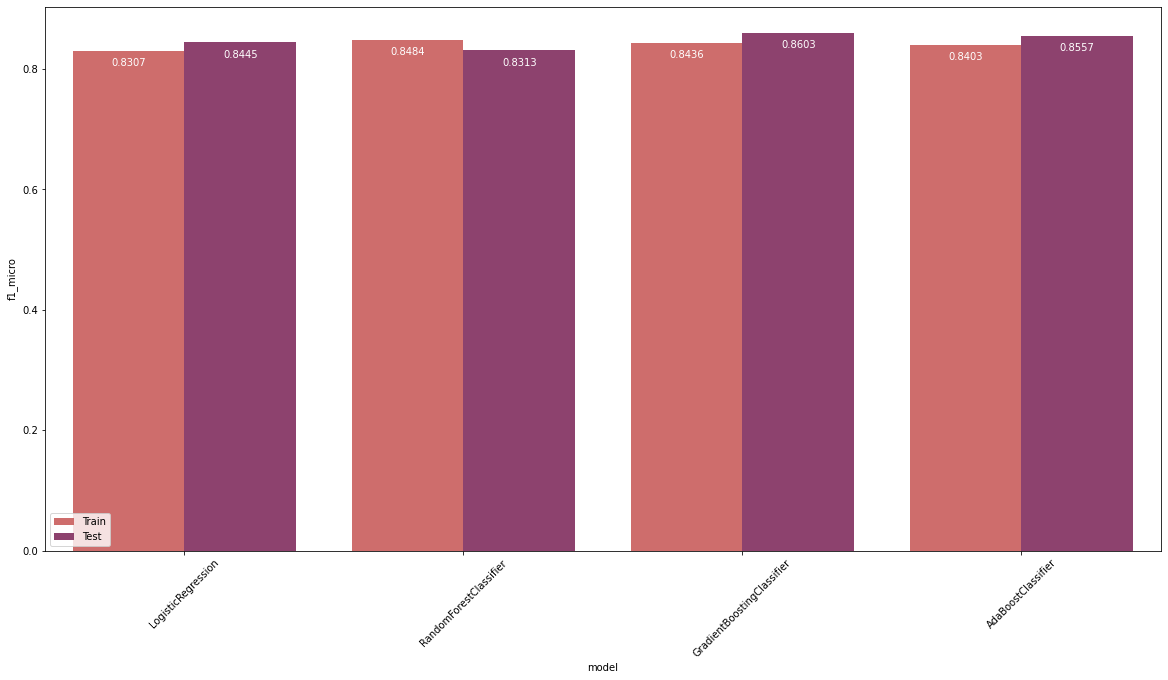

In [44]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

SMOTE_res, trained_models = runModels(models,SMOTE_X_train,SMOTE_y_train,X_test,y_test)

In [45]:
print_df(SMOTE_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.830678,0.830188,0.830188,0.770478
LogisticRegression,Test,0.844455,0.844455,0.844455,0.751805
RandomForestClassifier,Train,0.848391,0.946552,0.946552,0.932373
RandomForestClassifier,Test,0.831297,0.831297,0.831297,0.739986
GradientBoostingClassifier,Train,0.843566,0.848207,0.848207,0.796178
GradientBoostingClassifier,Test,0.860276,0.860276,0.860276,0.786735
AdaBoostClassifier,Train,0.840329,0.842649,0.842649,0.795238
AdaBoostClassifier,Test,0.855733,0.855733,0.855733,0.783577


### Using ADASYN to rebalance dataset

In [46]:
oversample = ADASYN()
ADASYN_X_train, ADASYN_y_train = oversample.fit_resample(X_train, y_train)
counter = Counter(ADASYN_y_train)
print(counter)

Counter({1: 11799, 0: 11694})


Running Model: LogisticRegression
[[3811 1200]
 [ 232 1141]]
-- Done. Duration: 69.33170485496521 s
Running Model: RandomForestClassifier
[[4154  857]
 [ 403  970]]
-- Done. Duration: 18.922523498535156 s
Running Model: GradientBoostingClassifier
[[3893 1118]
 [ 189 1184]]
-- Done. Duration: 17.080849170684814 s
Running Model: AdaBoostClassifier
[[3952 1059]
 [ 246 1127]]
-- Done. Duration: 8.383540153503418 s
GLOBAL DURATION: 113.7186176776886 s


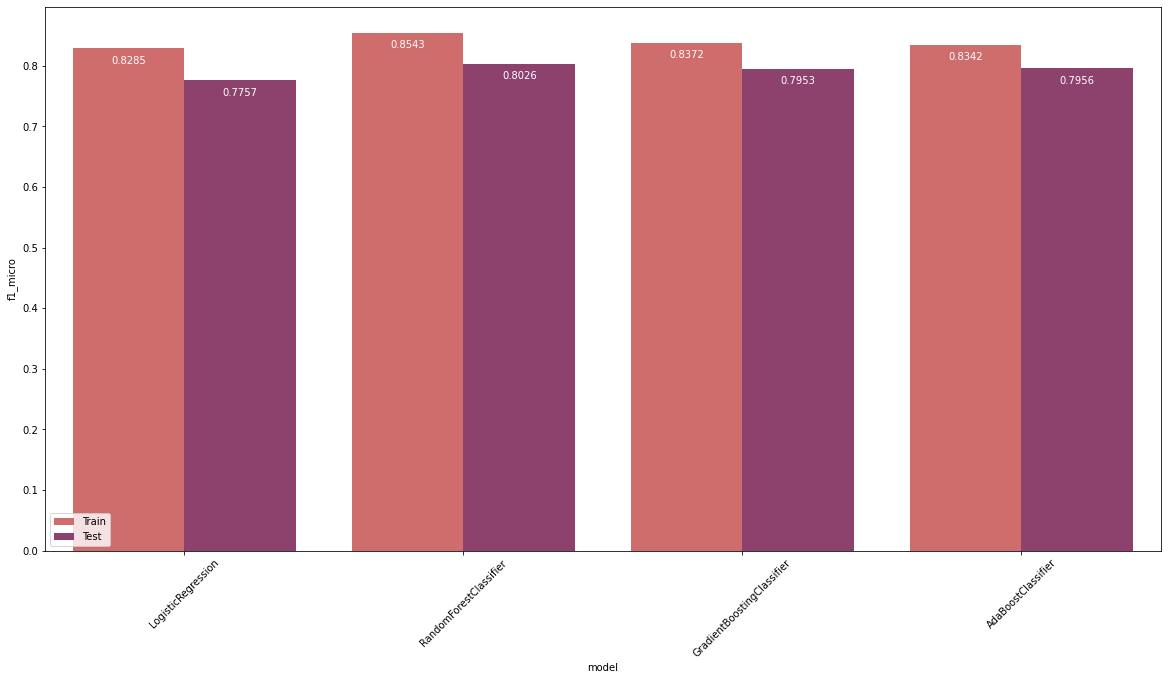

In [47]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

ADASYN_res, trained_models = runModels(models,ADASYN_X_train,ADASYN_y_train,X_test,y_test)

### Using Random Over Sampler

In [48]:
Counter(y_train)

Counter({0: 11694, 1: 3202})

In [49]:
ROS = RandomOverSampler(sampling_strategy=0.6)
ROS_X_train, ROS_y_train = ROS.fit_resample(X_train, y_train)

counter = Counter(ROS_y_train)
print(counter)

Counter({0: 11694, 1: 7016})


Running Model: LogisticRegression
[[4314  697]
 [ 371 1002]]
-- Done. Duration: 50.143664598464966 s
Running Model: RandomForestClassifier
[[4424  587]
 [ 506  867]]
-- Done. Duration: 14.945655345916748 s
Running Model: GradientBoostingClassifier
[[4294  717]
 [ 328 1045]]
-- Done. Duration: 13.830688953399658 s
Running Model: AdaBoostClassifier
[[4222  789]
 [ 329 1044]]
-- Done. Duration: 6.723668575286865 s
GLOBAL DURATION: 85.65959310531616 s


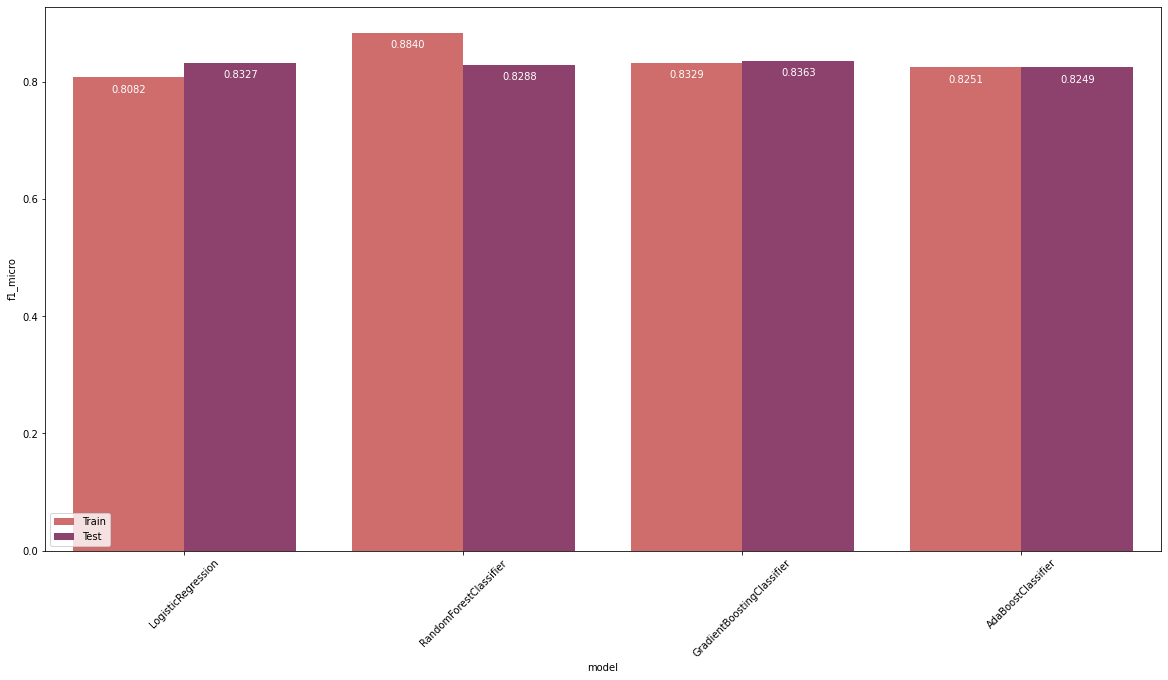

In [50]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

ROS_res, trained_models = runModels(models,ROS_X_train,ROS_y_train,X_test,y_test)

In [51]:
print_df(ROS_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.808177,0.808712,0.808712,0.792379
LogisticRegression,Test,0.832707,0.832707,0.832707,0.795347
RandomForestClassifier,Train,0.884019,0.947568,0.947568,0.946880
RandomForestClassifier,Test,0.828791,0.828791,0.828791,0.757161
GradientBoostingClassifier,Train,0.832924,0.837092,0.837092,0.829251
GradientBoostingClassifier,Test,0.836310,0.836310,0.836310,0.809011
AdaBoostClassifier,Train,0.825067,0.825708,0.825708,0.819774
AdaBoostClassifier,Test,0.824875,0.824875,0.824875,0.801463


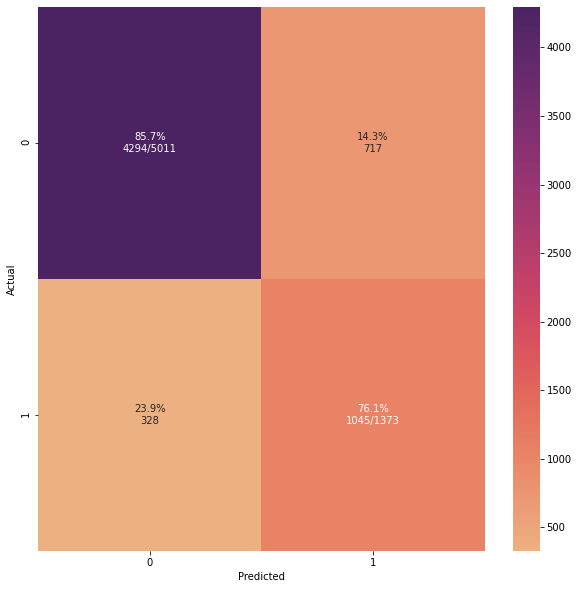

In [52]:
y_pred = modelGBC.predict(X_test)
cm_analysis(y_test, y_pred, modelGBC.classes_, ymap=None, figsize=(10,10))

### SMOTE and Tomek Links

In [53]:
from imblearn.under_sampling import TomekLinks

oversample = SMOTE(sampling_strategy=0.8)
SMOTE_X_train, SMOTE_y_train = oversample.fit_resample(X_train, y_train)

TKL = TomekLinks()
TKL_X_train, TKL_y_train = TKL.fit_resample(SMOTE_X_train, SMOTE_y_train)


counter = Counter(TKL_y_train)
print(counter)

Counter({0: 11528, 1: 9355})


Running Model: LogisticRegression
[[4077  934]
 [ 294 1079]]
-- Done. Duration: 58.476539850234985 s
Running Model: RandomForestClassifier
[[4313  698]
 [ 444  929]]
-- Done. Duration: 21.0684814453125 s
Running Model: GradientBoostingClassifier
[[4080  931]
 [ 249 1124]]
-- Done. Duration: 18.64964246749878 s
Running Model: AdaBoostClassifier
[[4132  879]
 [ 305 1068]]
-- Done. Duration: 7.804437160491943 s
GLOBAL DURATION: 106.00114631652832 s


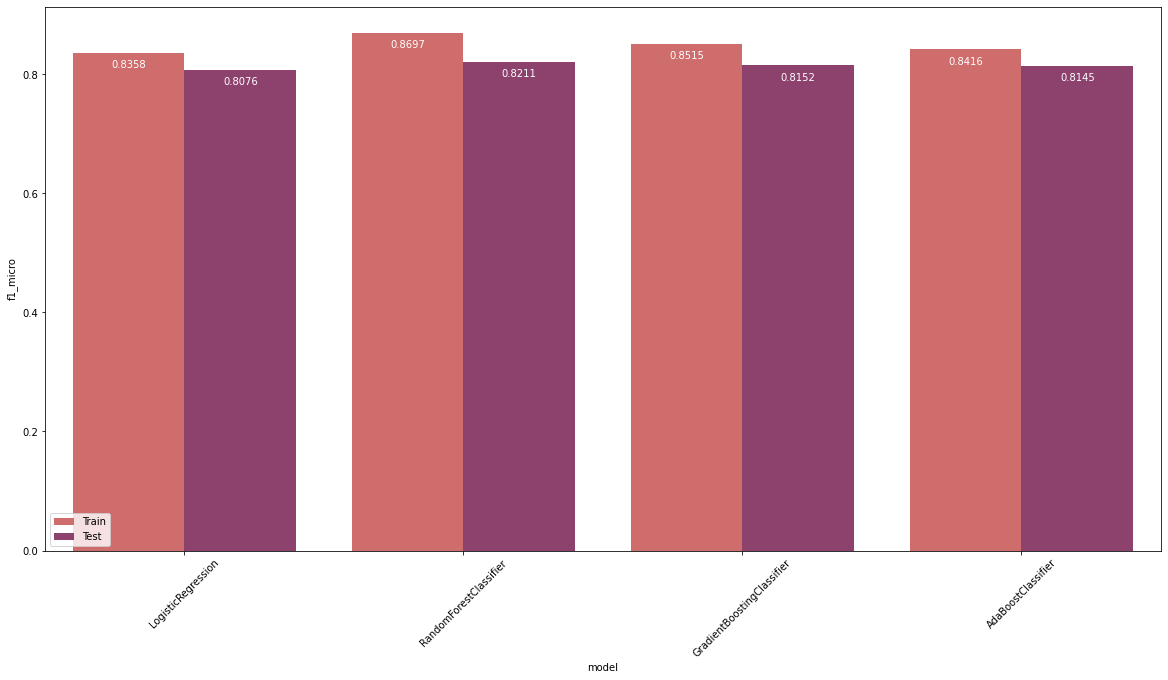

In [54]:
ROUS_res, trained_models = runModels(models,TKL_X_train,TKL_y_train,X_test,y_test)

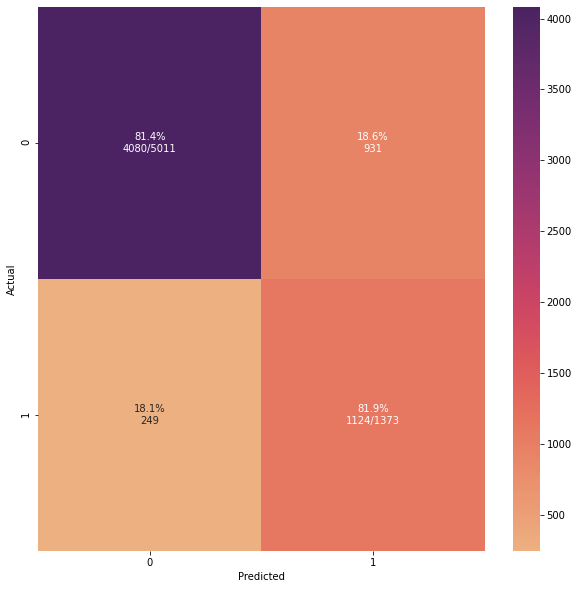

In [55]:
y_pred = modelGBC.predict(X_test)
cm_analysis(y_test, y_pred, modelGBC.classes_, ymap=None, figsize=(10,10))

### Using Random Under Sampler

In [56]:
RUS = RandomUnderSampler(sampling_strategy=0.3)
ROUS_X_train, ROUS_y_train = RUS.fit_resample(X_train, y_train)

counter = Counter(ROUS_y_train)
print(counter)

Counter({0: 10673, 1: 3202})


Running Model: LogisticRegression
[[4714  297]
 [ 650  723]]
-- Done. Duration: 34.44795823097229 s
Running Model: RandomForestClassifier
[[4587  424]
 [ 594  779]]
-- Done. Duration: 11.360467195510864 s
Running Model: GradientBoostingClassifier
[[4734  277]
 [ 600  773]]
-- Done. Duration: 11.060059785842896 s
Running Model: AdaBoostClassifier
[[4708  303]
 [ 600  773]]
-- Done. Duration: 4.5763349533081055 s
GLOBAL DURATION: 61.44897675514221 s


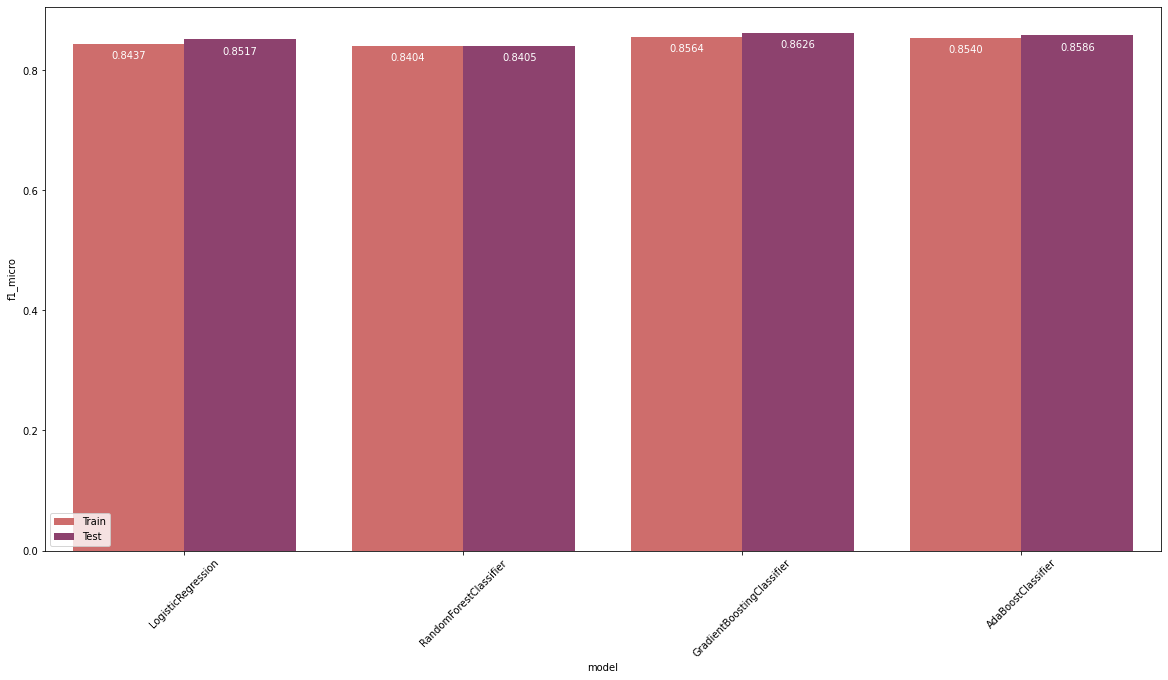

In [57]:
ROUS_res, trained_models = runModels(models,ROUS_X_train,ROUS_y_train,X_test,y_test)

In [58]:
print_df(ROUS_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.843749,0.844901,0.844901,0.737195
LogisticRegression,Test,0.851660,0.851660,0.851660,0.733657
RandomForestClassifier,Train,0.840360,0.951856,0.951856,0.918207
RandomForestClassifier,Test,0.840539,0.840539,0.840539,0.741378
GradientBoostingClassifier,Train,0.856433,0.860468,0.860468,0.759884
GradientBoostingClassifier,Test,0.862625,0.862625,0.862625,0.753861
AdaBoostClassifier,Train,0.853983,0.856793,0.856793,0.759025
AdaBoostClassifier,Test,0.858553,0.858553,0.858553,0.751267


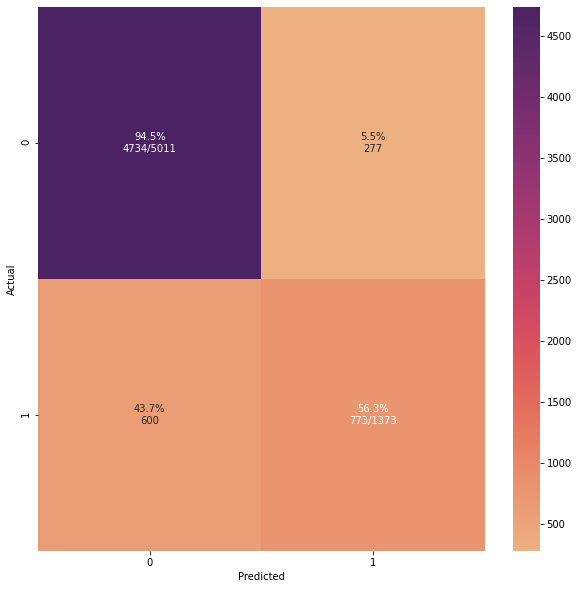

In [59]:
y_pred = modelGBC.predict(X_test)
cm_analysis(y_test, y_pred, modelGBC.classes_, ymap=None, figsize=(10,10))

### Using Tomek Links to undersample data

In [60]:
from imblearn.under_sampling import TomekLinks
print(counter)
TKL = TomekLinks()
TKL_X_train, TKL_y_train = TKL.fit_resample(X_train, y_train)

counter = Counter(TKL_y_train)
print(counter)

Counter({0: 10673, 1: 3202})
Counter({0: 11436, 1: 3202})


Running Model: LogisticRegression
[[4699  312]
 [ 657  716]]
-- Done. Duration: 35.33456635475159 s
Running Model: RandomForestClassifier
[[4587  424]
 [ 604  769]]
-- Done. Duration: 12.751276731491089 s
Running Model: GradientBoostingClassifier
[[4722  289]
 [ 616  757]]
-- Done. Duration: 11.161391735076904 s
Running Model: AdaBoostClassifier
[[4691  320]
 [ 588  785]]
-- Done. Duration: 4.811037063598633 s
GLOBAL DURATION: 64.07854747772217 s


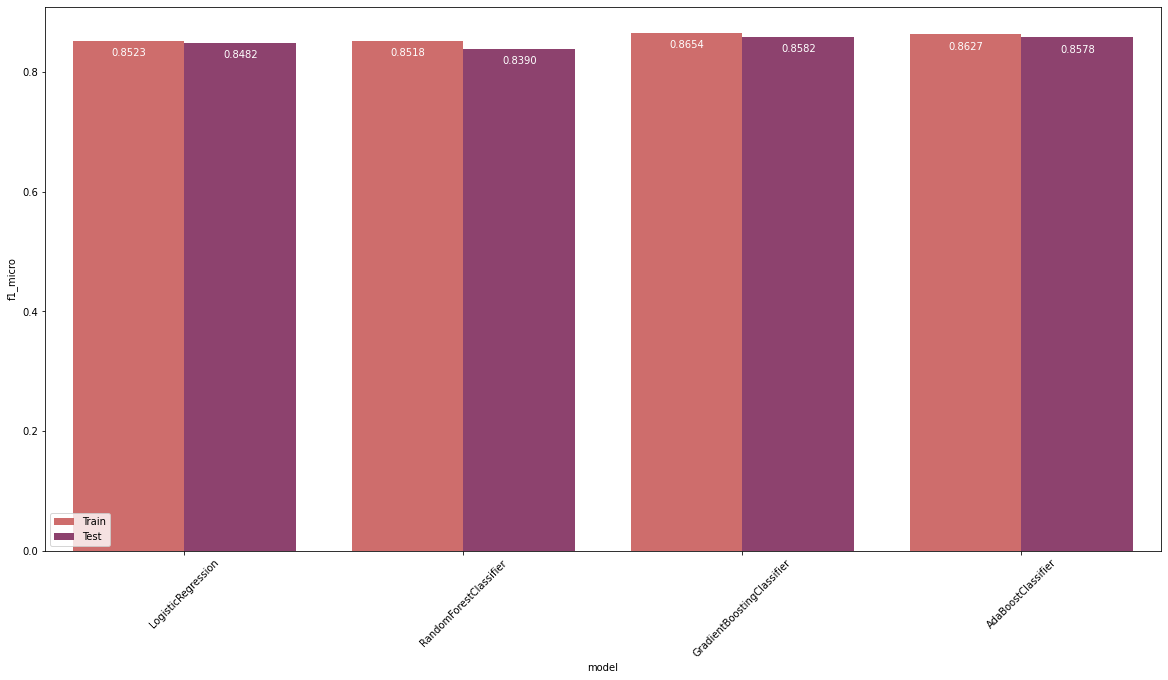

In [61]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

TKL_res, trained_models = runModels(models,TKL_X_train,TKL_y_train,X_test,y_test)

In [62]:
print_df(TKL_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.852302,0.852780,0.852780,0.739495
LogisticRegression,Test,0.848214,0.848214,0.848214,0.729611
RandomForestClassifier,Train,0.851823,0.952453,0.952453,0.914141
RandomForestClassifier,Test,0.838972,0.838972,0.838972,0.737737
GradientBoostingClassifier,Train,0.865418,0.869313,0.869313,0.761768
GradientBoostingClassifier,Test,0.858239,0.858239,0.858239,0.746837
AdaBoostClassifier,Train,0.862685,0.863984,0.863984,0.765329
AdaBoostClassifier,Test,0.857769,0.857769,0.857769,0.753941


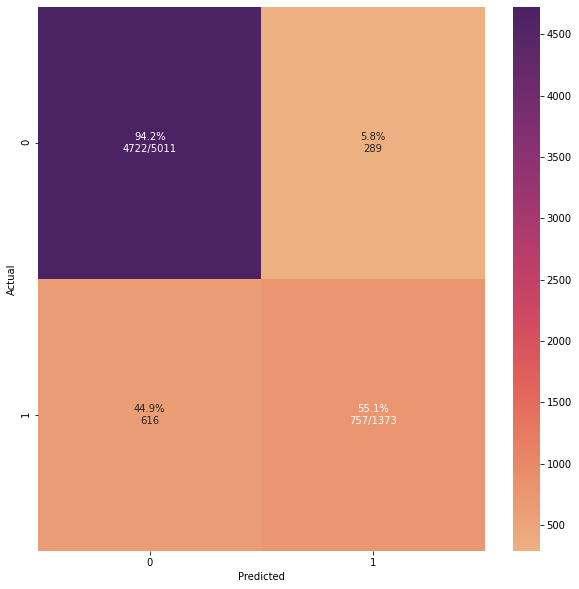

In [63]:
y_pred = modelGBC.predict(X_test)
cm_analysis(y_test, y_pred, modelGBC.classes_, ymap=None, figsize=(10,10))

### Using Combine Tomek Links with Random OverSampling to undersample data

In [64]:
ROS = RandomOverSampler(sampling_strategy=0.3)
TLRO_X_train, TLRO_y_train = ROS.fit_resample(TKL_X_train, TKL_y_train )
counter = Counter(TLRO_y_train)
print(counter)

Counter({0: 11436, 1: 3430})


Running Model: LogisticRegression
[[4673  338]
 [ 631  742]]
-- Done. Duration: 40.4565544128418 s
Running Model: RandomForestClassifier
[[4565  446]
 [ 586  787]]
-- Done. Duration: 12.789144277572632 s
Running Model: GradientBoostingClassifier
[[4706  305]
 [ 588  785]]
-- Done. Duration: 11.29790997505188 s
Running Model: AdaBoostClassifier
[[4678  333]
 [ 572  801]]
-- Done. Duration: 5.3154380321502686 s
GLOBAL DURATION: 69.86107635498047 s


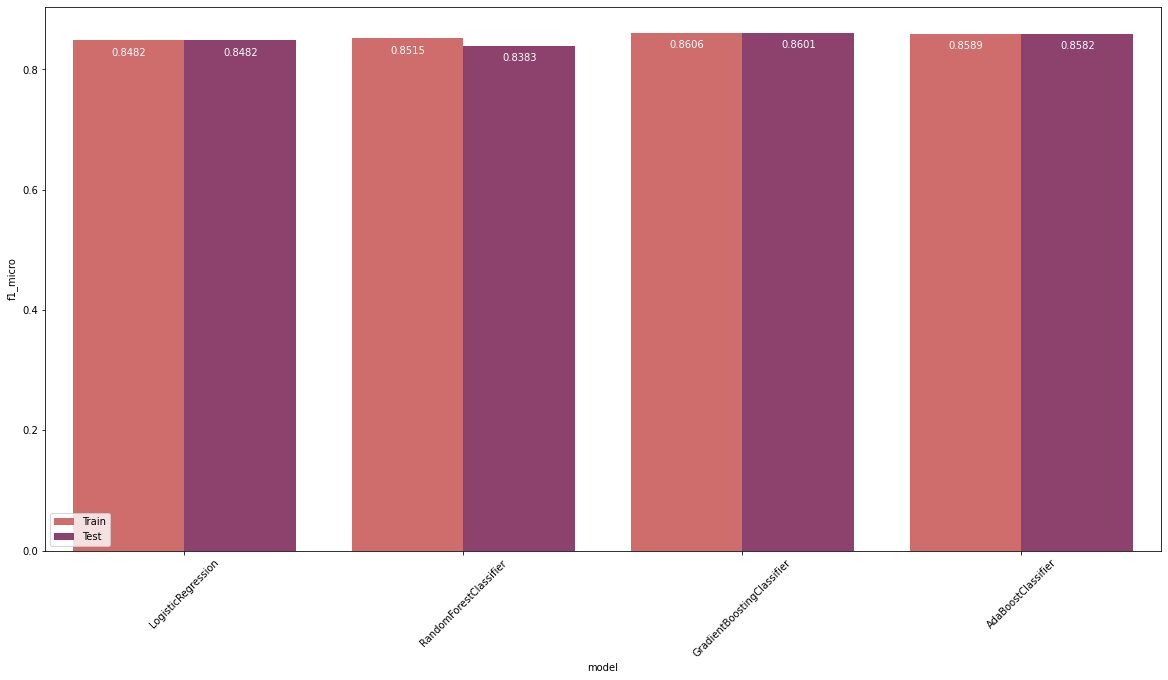

In [65]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

TLRO_res, trained_models = runModels(models,TLRO_X_train,TLRO_y_train,X_test,y_test)

No Skill: ROC AUC=0.500
GradientBoostingClassifier  : ROC AUC=0.906


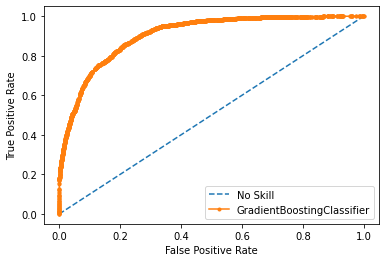

In [66]:
plot_roc_auc(modelGBC,X_test,y_test)

GradientBoostingClassifier  : f1=0.637 auc=0.753


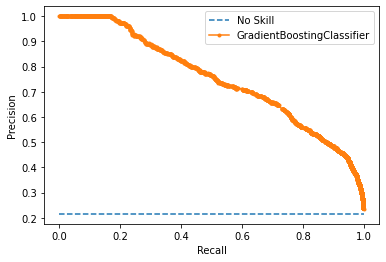

In [67]:
plot_precision_recall(modelGBC,X_test,y_test)

In [68]:
print_df(TLRO_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.848176,0.849119,0.849119,0.745692
LogisticRegression,Test,0.848214,0.848214,0.848214,0.736485
RandomForestClassifier,Train,0.851473,0.951769,0.951769,0.919259
RandomForestClassifier,Test,0.838346,0.838346,0.838346,0.742097
GradientBoostingClassifier,Train,0.860554,0.863581,0.863581,0.765706
GradientBoostingClassifier,Test,0.860119,0.860119,0.860119,0.755437
AdaBoostClassifier,Train,0.858872,0.860218,0.860218,0.770867
AdaBoostClassifier,Test,0.858239,0.858239,0.858239,0.758470


### Using NearMiss to undersample data

In [69]:
from imblearn.under_sampling import AllKNN

NM = NearMiss(version=1,sampling_strategy=0.3)
NM_X_train, NM_y_train = NM.fit_resample(X_train, y_train)

counter = Counter(NM_y_train)
print(counter)

Counter({0: 10673, 1: 3202})


Running Model: LogisticRegression
[[4571  440]
 [ 632  741]]
-- Done. Duration: 24.466845273971558 s
Running Model: RandomForestClassifier
[[4430  581]
 [ 598  775]]
-- Done. Duration: 11.942187786102295 s
Running Model: GradientBoostingClassifier
[[4567  444]
 [ 600  773]]
-- Done. Duration: 12.171584367752075 s
Running Model: AdaBoostClassifier
[[4588  423]
 [ 589  784]]
-- Done. Duration: 4.5815184116363525 s
GLOBAL DURATION: 53.16711139678955 s


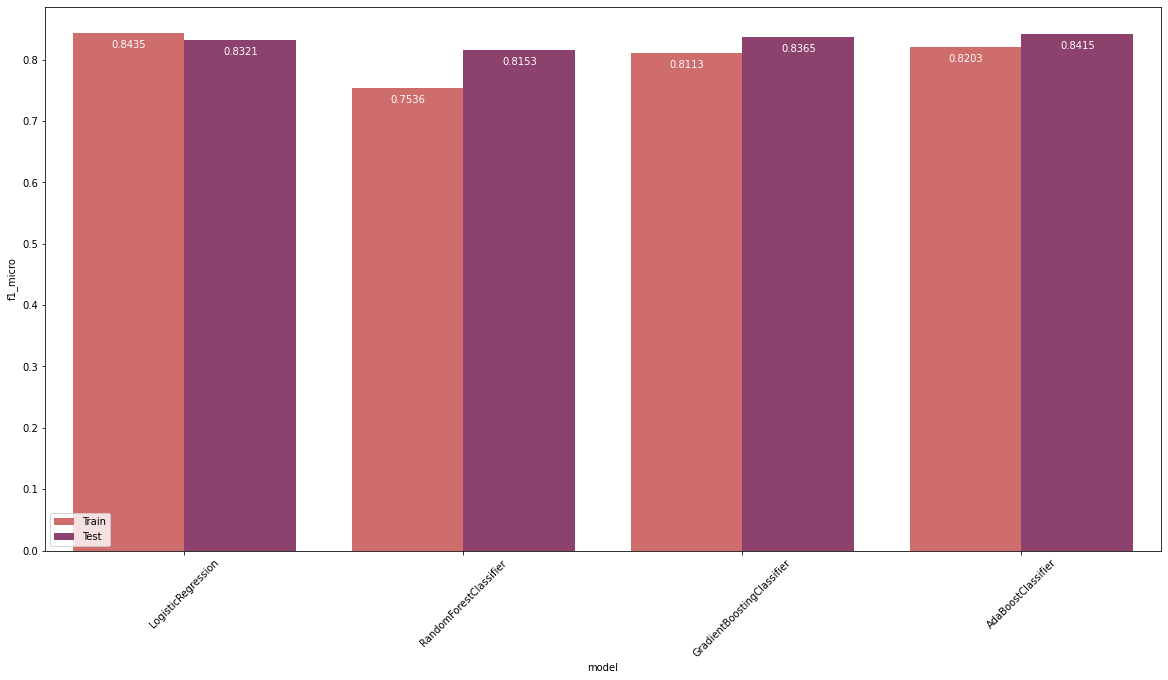

In [70]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

NM_res, trained_models = runModels(models,NM_X_train,NM_y_train,X_test,y_test)

### Choose 1 method

In [71]:
X_train = TKL_X_train
y_train = TKL_y_train
X_test  = X_test_source
y_test = y_test_source

## Data Scaling

### StandardScaler

In [72]:
scaler = StandardScaler()
SScale_X_train = scaler.fit_transform(X_train)
SScale_X_test = scaler.fit_transform(X_test)
SScale_y_train = y_train
SScale_y_test = y_test

Running Model: LogisticRegression
[[4711  300]
 [ 668  705]]
-- Done. Duration: 1.330932855606079 s
Running Model: RandomForestClassifier
[[4573  438]
 [ 633  740]]
-- Done. Duration: 11.314940452575684 s
Running Model: GradientBoostingClassifier
[[4713  298]
 [ 640  733]]
-- Done. Duration: 11.890565395355225 s
Running Model: AdaBoostClassifier
[[4685  326]
 [ 604  769]]
-- Done. Duration: 5.108559846878052 s
GLOBAL DURATION: 29.647091150283813 s


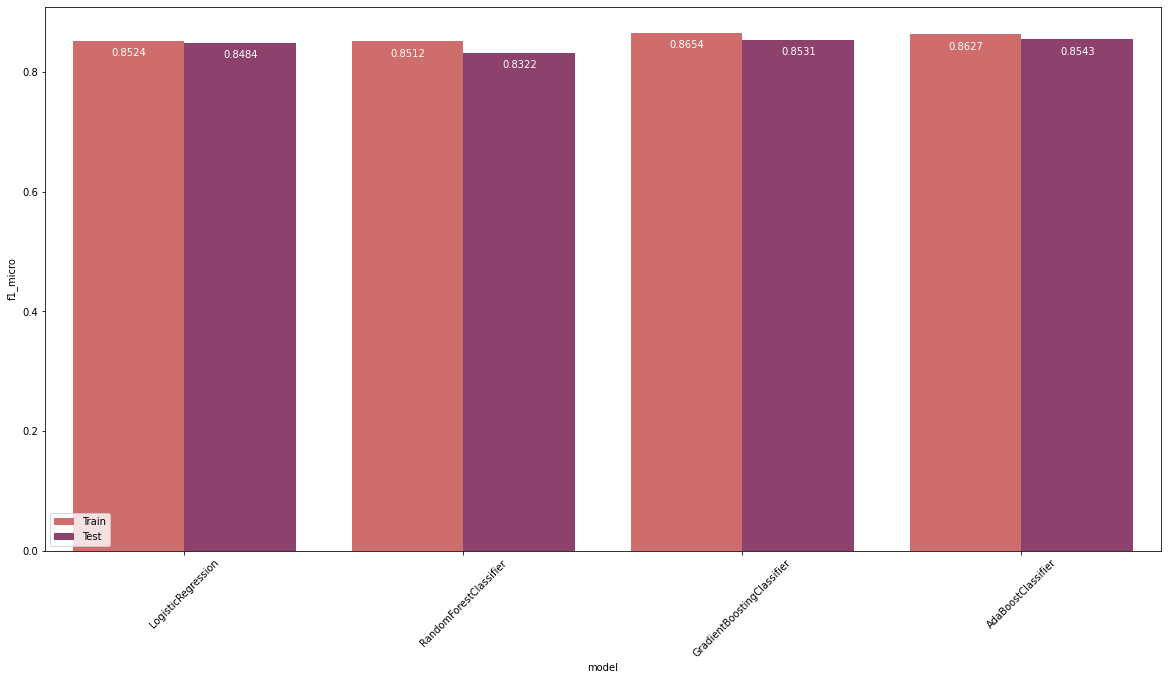

In [73]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

SScaler_res, trained_models = runModels(models,SScale_X_train,SScale_y_train,SScale_X_test,SScale_y_test)

In [74]:
SScaler_res.style.hide_index()

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.852439,0.853532,0.853532,0.740201
LogisticRegression,Test,0.848371,0.848371,0.848371,0.726803
RandomForestClassifier,Train,0.851209,0.952453,0.952453,0.914479
RandomForestClassifier,Test,0.832237,0.832237,0.832237,0.725779
GradientBoostingClassifier,Train,0.865418,0.869313,0.869313,0.761768
GradientBoostingClassifier,Test,0.853070,0.853070,0.853070,0.737199
AdaBoostClassifier,Train,0.862685,0.863984,0.863984,0.765329
AdaBoostClassifier,Test,0.854323,0.854323,0.854323,0.747515


### MinMax 0:1

In [75]:
min_max_0_1 = MinMaxScaler(feature_range=(0, 1))
MinMaxScaler_01_X_train = min_max_0_1.fit_transform(X_train)
MinMaxScaler_01_X_test = min_max_0_1.fit_transform(X_test)
MinMaxScaler_01_y_train = y_train
MinMaxScaler_01_y_test = y_test

Running Model: LogisticRegression
[[4699  312]
 [ 661  712]]
-- Done. Duration: 2.970038414001465 s
Running Model: RandomForestClassifier
[[4569  442]
 [ 598  775]]
-- Done. Duration: 15.06308126449585 s
Running Model: GradientBoostingClassifier
[[4719  292]
 [ 618  755]]
-- Done. Duration: 17.257781744003296 s
Running Model: AdaBoostClassifier
[[4689  322]
 [ 591  782]]
-- Done. Duration: 7.362299203872681 s
GLOBAL DURATION: 42.687174558639526 s


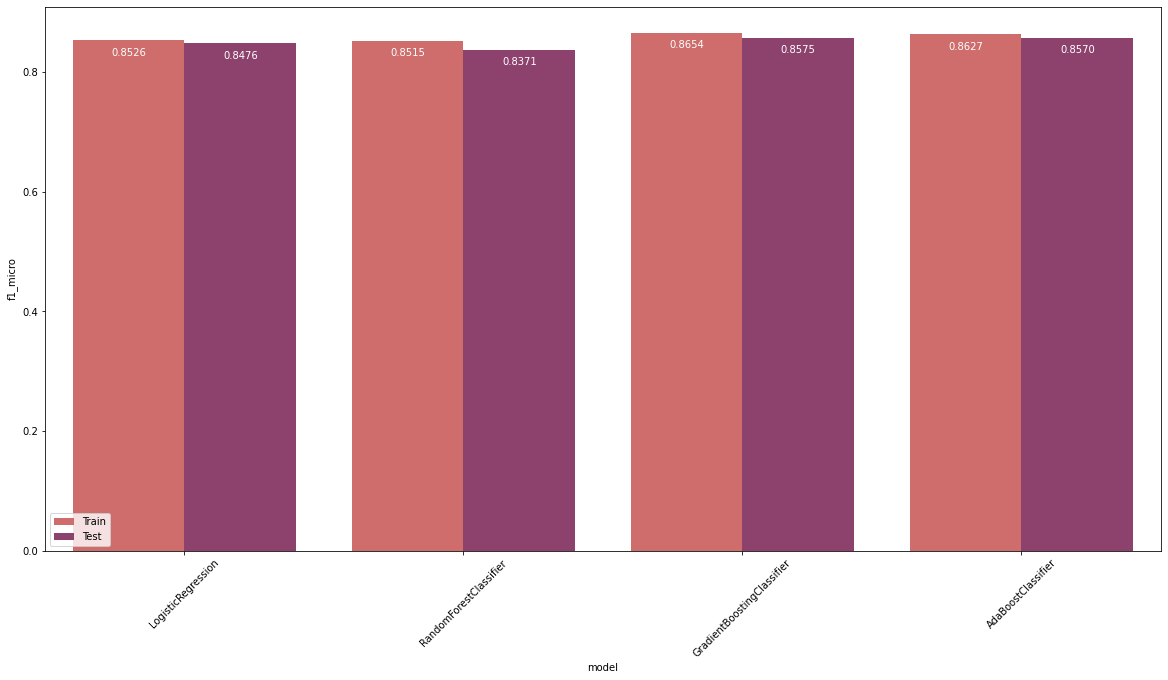

In [76]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

MinMaxScaler_01_res, trained_models = runModels(models,MinMaxScaler_01_X_train,MinMaxScaler_01_y_train,MinMaxScaler_01_X_test,MinMaxScaler_01_y_test)

### MinMax -1:1

In [77]:
min_max_1_1 = MinMaxScaler(feature_range=(-1, 1))
MinMaxScaler_11_X_train = min_max_1_1.fit_transform(X_train)
MinMaxScaler_11_X_test = min_max_1_1.fit_transform(X_test)
MinMaxScaler_11_y_train = y_train
MinMaxScaler_11_y_test = y_test

Running Model: LogisticRegression
[[4707  304]
 [ 659  714]]
-- Done. Duration: 3.913677453994751 s
Running Model: RandomForestClassifier
[[4570  441]
 [ 603  770]]
-- Done. Duration: 12.939122438430786 s
Running Model: GradientBoostingClassifier
[[4719  292]
 [ 618  755]]
-- Done. Duration: 12.74173355102539 s
Running Model: AdaBoostClassifier
[[4689  322]
 [ 591  782]]
-- Done. Duration: 5.224438190460205 s
GLOBAL DURATION: 34.81897163391113 s


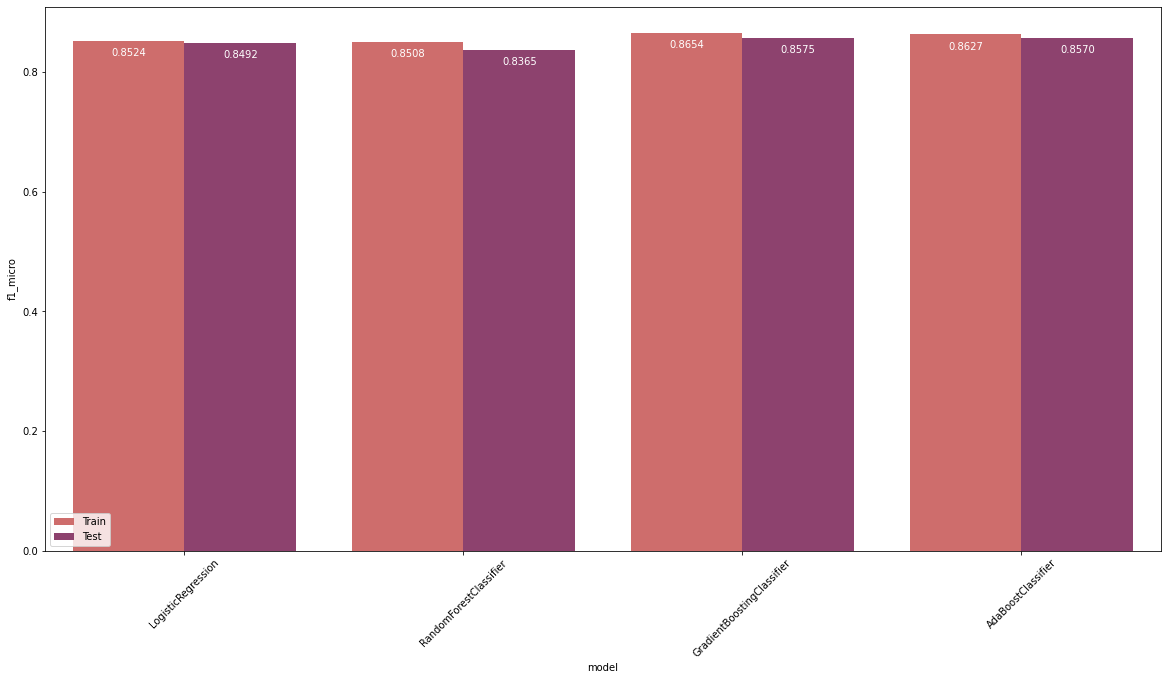

In [78]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

MinMaxScaler_11_res, trained_models = runModels(models,MinMaxScaler_11_X_train,MinMaxScaler_11_y_train,MinMaxScaler_11_X_test,MinMaxScaler_11_y_test)

In [79]:
print_df(MinMaxScaler_11_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.852439,0.852917,0.852917,0.738795
LogisticRegression,Test,0.849154,0.849154,0.849154,0.729681
RandomForestClassifier,Train,0.850798,0.952453,0.952453,0.917514
RandomForestClassifier,Test,0.836466,0.836466,0.836466,0.736405
GradientBoostingClassifier,Train,0.865418,0.869313,0.869313,0.761768
GradientBoostingClassifier,Test,0.857456,0.857456,0.857456,0.745809
AdaBoostClassifier,Train,0.862685,0.863984,0.863984,0.765329
AdaBoostClassifier,Test,0.856986,0.856986,0.856986,0.752649


### RobustScaler

In [80]:
robust_scaler = RobustScaler()
RobScaler_X_train = robust_scaler.fit_transform(X_train)
RobScaler_X_test = robust_scaler.fit_transform(X_test)
RobScaler_y_train = y_train
RobScaler_y_test = y_test

Running Model: LogisticRegression
[[4702  309]
 [ 653  720]]
-- Done. Duration: 15.999529838562012 s
Running Model: RandomForestClassifier
[[4575  436]
 [ 603  770]]
-- Done. Duration: 11.388027667999268 s
Running Model: GradientBoostingClassifier
[[4722  289]
 [ 616  757]]
-- Done. Duration: 11.712865829467773 s
Running Model: AdaBoostClassifier
[[4691  320]
 [ 588  785]]
-- Done. Duration: 4.933565378189087 s
GLOBAL DURATION: 44.03398871421814 s


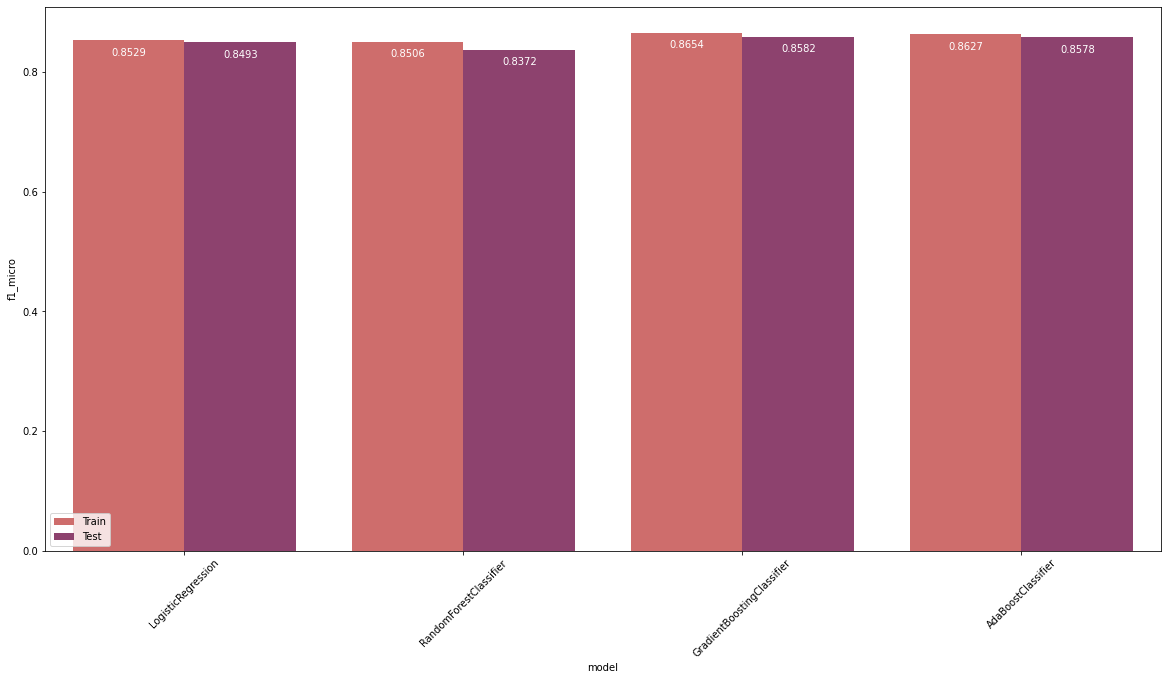

In [81]:
models = [modellog,
          modelRF,
          modelGBC,
          modelAda
         ]

RobScaler_res, trained_models = runModels(models,RobScaler_X_train,RobScaler_y_train,RobScaler_X_test,RobScaler_y_test)

In [82]:
RobScaler_res.style.hide_index()

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
LogisticRegression,Train,0.852917,0.853737,0.853737,0.740219
LogisticRegression,Test,0.849311,0.849311,0.849311,0.731367
RandomForestClassifier,Train,0.850594,0.952453,0.952453,0.916727
RandomForestClassifier,Test,0.837249,0.837249,0.837249,0.736904
GradientBoostingClassifier,Train,0.865418,0.869313,0.869313,0.761768
GradientBoostingClassifier,Test,0.858239,0.858239,0.858239,0.746837
AdaBoostClassifier,Train,0.862685,0.863984,0.863984,0.765329
AdaBoostClassifier,Test,0.857769,0.857769,0.857769,0.753941


In [83]:
# Choosing one:
X_train = MinMaxScaler_11_X_train
y_train = MinMaxScaler_11_y_train
X_test = MinMaxScaler_11_X_test
y_test = MinMaxScaler_11_y_test

## Feature Selection
In this section, we will eliminate noise from the model.

In [84]:
from itertools import compress
select = SelectFromModel(modelRF, threshold='mean',prefit=True)
feature_index = [i for i in range(X_train.shape[1])]
features = list(compress(feature_index, select.get_support())) 
X.columns[features]

Index(['Years of Education', 'Working Hours per week', 'Money Received', 'Age',
       'MStatus_married', 'MStatus_not_married', 'Lwith_spouse'],
      dtype='object')

<AxesSubplot:xlabel='Value', ylabel='Col'>

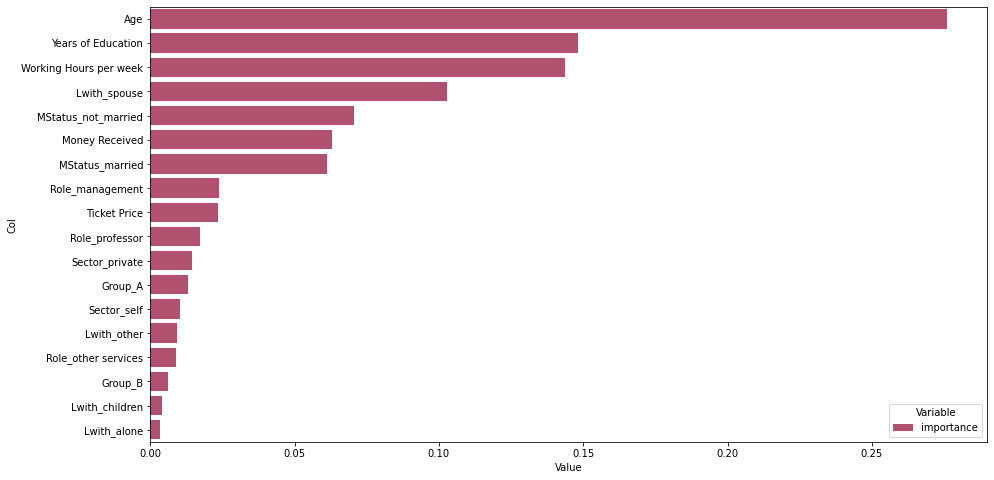

In [85]:
import seaborn as sns
columns = processedTrainingData.columns
zippy = pd.DataFrame(modelRF.feature_importances_, columns = ['importance'])
zippy['col'] = X.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy, palette='flare')

In [86]:
#features = tidy[0:10].index

Running Model: LogisticRegression
[[4654  357]
 [ 668  705]]
-- Done. Duration: 0.5189259052276611 s
Running Model: RandomForestClassifier
[[4550  461]
 [ 651  722]]
-- Done. Duration: 9.707848310470581 s
Running Model: GradientBoostingClassifier
[[4693  318]
 [ 618  755]]
-- Done. Duration: 7.702302694320679 s
Running Model: AdaBoostClassifier
[[4669  342]
 [ 642  731]]
-- Done. Duration: 3.7049384117126465 s
GLOBAL DURATION: 21.642213821411133 s


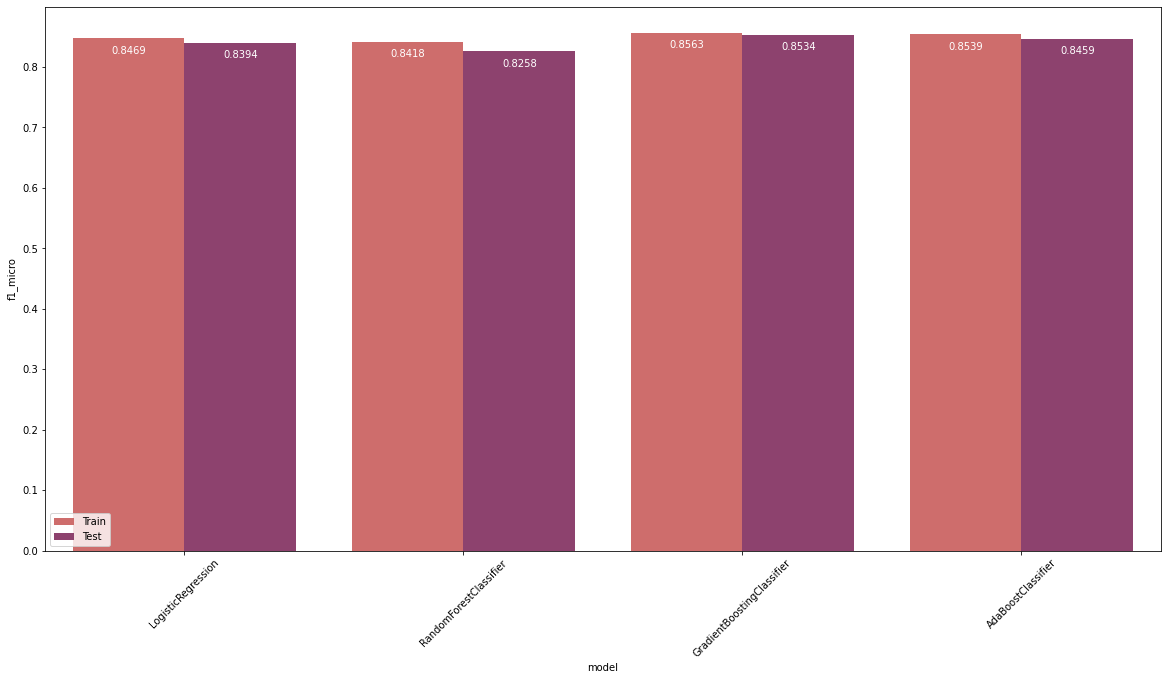

In [87]:
Selected_X_train = X_train[:,features]
Selected_X_test = X_test[:,features]
Selected_y_train = y_train
Selected_y_Test = y_test


select_RES, models = runModels(models,Selected_X_train,Selected_y_train,Selected_X_test,Selected_y_Test)

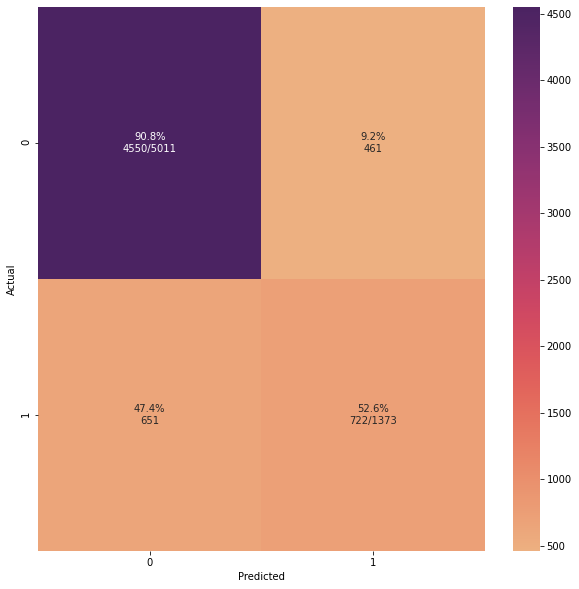

In [88]:
modelAda = models[1]
modelGBC = models[0]
y_pred = modelAda.predict(Selected_X_test)
cm_analysis(Selected_y_Test, y_pred, modelAda.classes_, ymap=None, figsize=(10,10))

### Hyperpatameterization

In [89]:
hyperopt_X_train = Selected_X_train
hyperopt_y_train = Selected_y_train
hyperopt_X_test = Selected_X_test
hyperopt_y_test = Selected_y_Test

In [92]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch1.fit(hyperopt_X_train, hyperopt_y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(20, 81, 10)},
             scoring='f1_micro')

In [93]:
 gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 60}, 0.855512787482661)

In [94]:
n_estimators = 60
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=n_estimators, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch2.fit(hyperopt_X_train, hyperopt_y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_estimators=60,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(200, 1001, 200)},
             scoring='f1_micro')

In [95]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 9, 'min_samples_split': 1000}, 0.8569476104331073)

In [96]:
max_depth =9 
min_samples_split=1000
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=n_estimators,max_depth=max_depth,max_features='sqrt',min_samples_split=min_samples_split, subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='f1_micro',n_jobs=4, cv=5)
gsearch3.fit(hyperopt_X_train, hyperopt_y_train)
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 70, 'min_samples_split': 1800}, 0.8563326696425404)

In [97]:
min_samples_leaf = 70
min_samples_split = 1800
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt', n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=10),
param_grid = param_test5, scoring='f1_micro',n_jobs=4, cv=5)
gsearch5.fit(hyperopt_X_train, hyperopt_y_train)
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.8}, 0.8563326696425404)

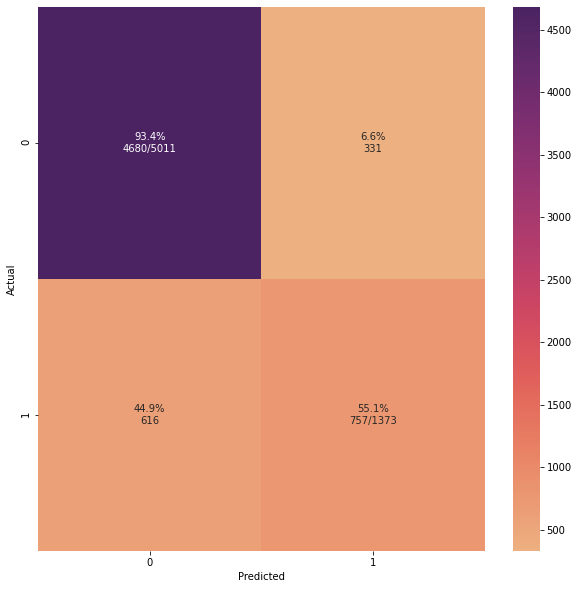

In [98]:
subsample = 0.8
modelGB =  GradientBoostingClassifier(learning_rate=0.1,subsample=subsample,max_features='sqrt', n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=10)
modelGB.fit(hyperopt_X_train, hyperopt_y_train)
y_pred = modelGB.predict(hyperopt_X_test)
cm_analysis(hyperopt_y_test, y_pred, modelGB.classes_, ymap=None, figsize=(10,10))

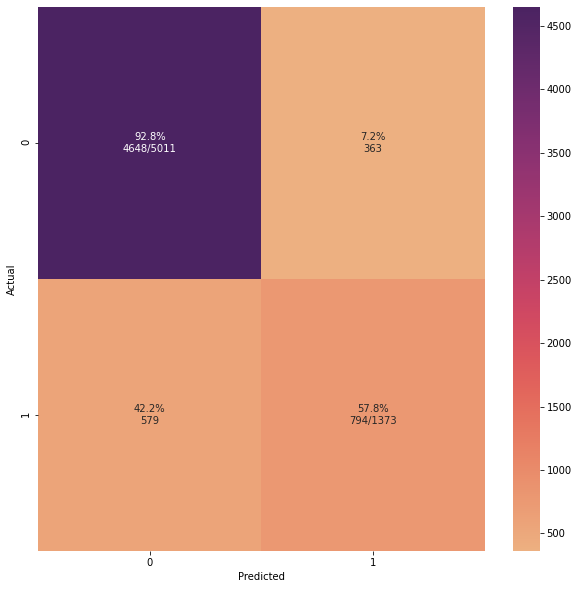

In [99]:
modelGB =  GradientBoostingClassifier(learning_rate=0.5,subsample=subsample,max_features='sqrt', n_estimators=140,max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=10)
modelGB.fit(hyperopt_X_train, hyperopt_y_train)
y_pred = modelGB.predict(hyperopt_X_test)
cm_analysis(hyperopt_y_test, y_pred, modelGB.classes_, ymap=None, figsize=(10,10))

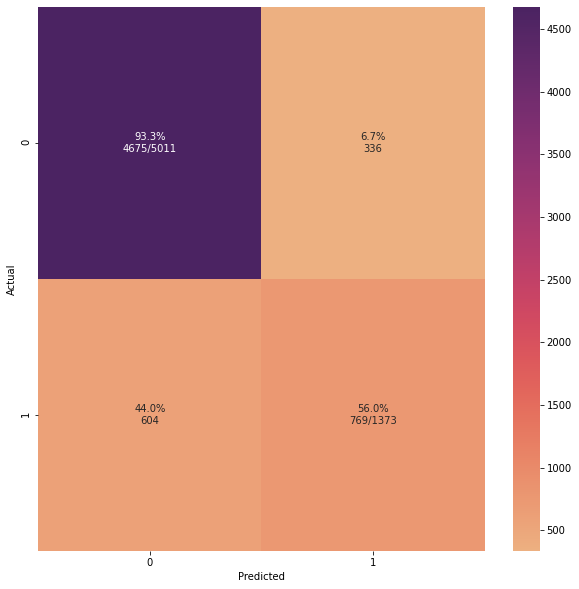

In [100]:
modelGB =  GradientBoostingClassifier(learning_rate=0.005,subsample=subsample,max_features='sqrt', n_estimators=1500,max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=10)
modelGB.fit(hyperopt_X_train, hyperopt_y_train)
y_pred = modelGB.predict(hyperopt_X_test)
cm_analysis(hyperopt_y_test, y_pred, modelGB.classes_, ymap=None, figsize=(10,10))

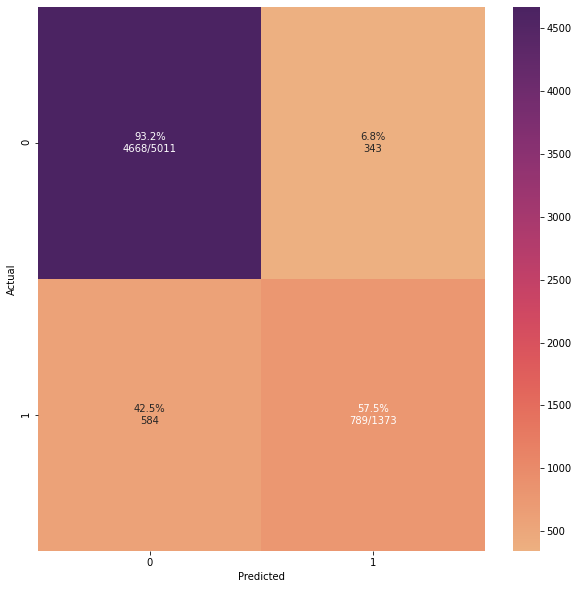

In [101]:
modelGB =  GradientBoostingClassifier(learning_rate=0.02,subsample=subsample,max_features='sqrt', n_estimators=900,max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=10)
modelGB.fit(hyperopt_X_train, hyperopt_y_train)
y_pred = modelGB.predict(hyperopt_X_test)
cm_analysis(hyperopt_y_test, y_pred, modelGB.classes_, ymap=None, figsize=(10,10))

In [102]:
from sklearn.model_selection import KFold
ada=AdaBoostClassifier()
crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)
search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1]}
modelAda=GridSearchCV(estimator=ada,param_grid=search_grid,scoring='f1_micro',n_jobs=1,cv=crossvalidation)
modelAda.fit(hyperopt_X_train, hyperopt_y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=AdaBoostClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': [500, 1000, 2000]},
             scoring='f1_micro')

In [103]:
modelAda.best_params_

{'learning_rate': 0.1, 'n_estimators': 1000}

In [104]:
modelAda=AdaBoostClassifier(learning_rate=0.1,n_estimators=2000)
modelGB =  GradientBoostingClassifier(learning_rate=0.02,subsample=subsample,max_features='sqrt', n_estimators=900,max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=10)

Running Model: GradientBoostingClassifier
[[4668  343]
 [ 584  789]]
-- Done. Duration: 63.28972148895264 s
Running Model: AdaBoostClassifier
[[4700  311]
 [ 630  743]]
-- Done. Duration: 148.26120734214783 s
GLOBAL DURATION: 211.55092883110046 s


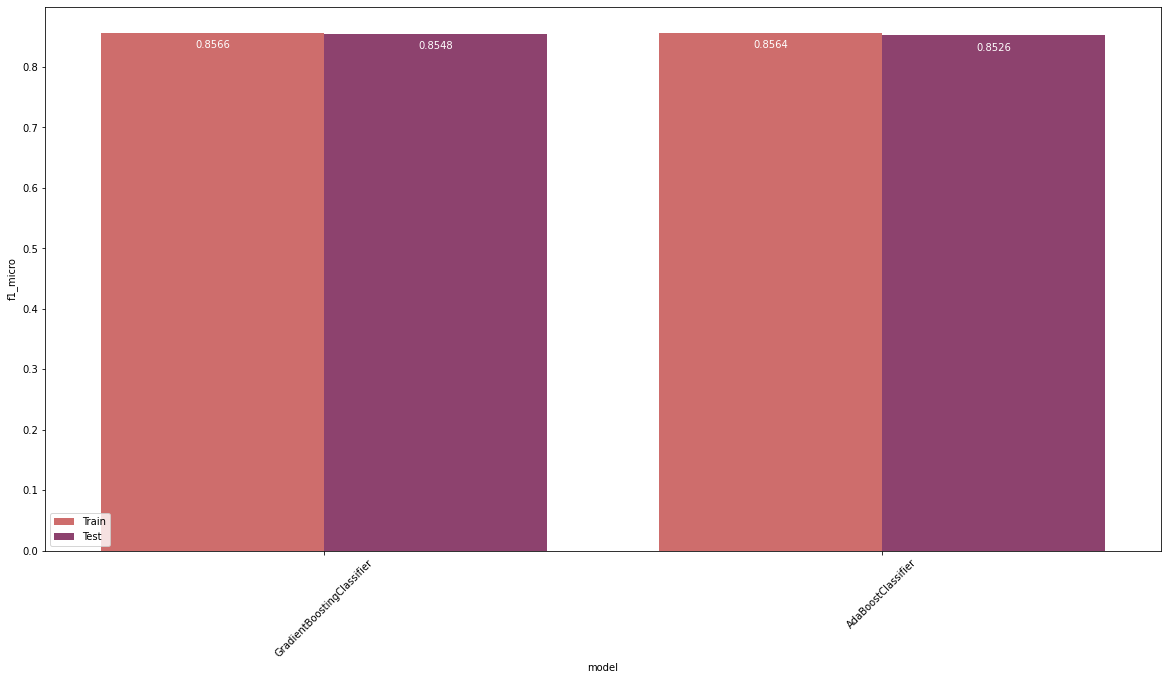

In [105]:
models = [modelGB,modelAda]
hyper_res, models = runModels(models,hyperopt_X_train,hyperopt_y_train,hyperopt_X_test,hyperopt_y_test)

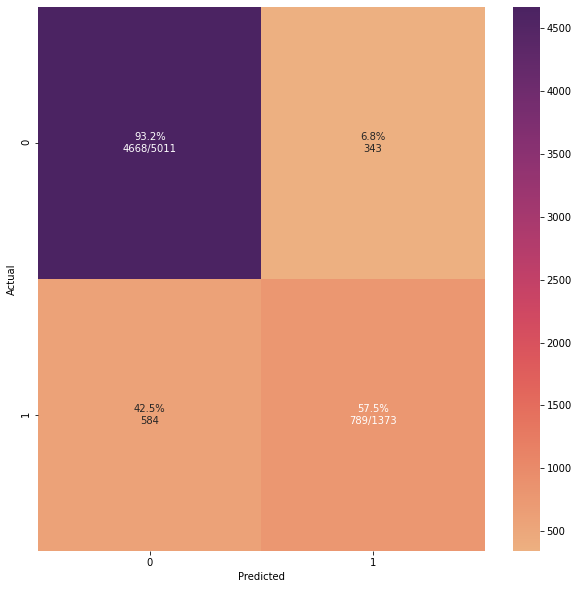

In [112]:
modelGB = models[0]
modelAda = models[1]
y_pred = modelGB.predict(hyperopt_X_test)
cm_analysis(hyperopt_y_test, y_pred, modelAda.classes_, ymap=None, figsize=(10,10))

No Skill: ROC AUC=0.500
GradientBoostingClassifier  : ROC AUC=0.899


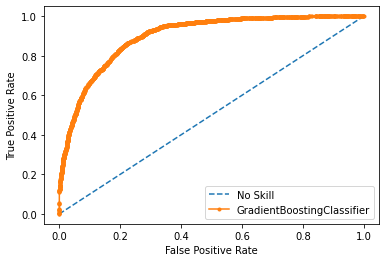

In [116]:
plot_roc_auc(modelGB,hyperopt_X_test, hyperopt_y_test)

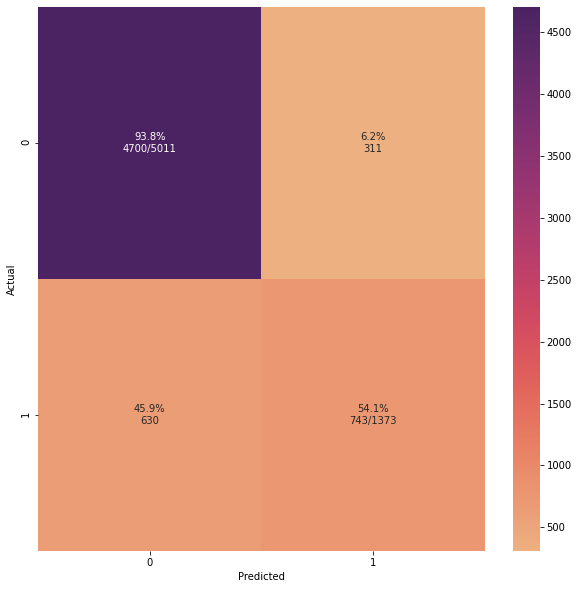

In [107]:
y_pred = modelAda.predict(hyperopt_X_test)
cm_analysis(hyperopt_y_test, y_pred, modelAda.classes_, ymap=None, figsize=(10,10))

In [108]:
print_df(hyper_res)

model,Stage,f1_micro,precision_micro,recall_micro,roc_auc_micro
GradientBoostingClassifier,Train,0.856606,0.863574,0.863574,0.764954
GradientBoostingClassifier,Test,0.854793,0.854793,0.854793,0.753102
AdaBoostClassifier,Train,0.856401,0.857836,0.857836,0.747115
AdaBoostClassifier,Test,0.852600,0.852600,0.852600,0.739544


# Choose a model here, so that the next step is always consistent


In [109]:
MODEL_CHOSEN = modelGB

## Produce File for Submission

In [110]:
prepped_data_submission = DataPreProcessing(data_test)
prepped_data_submission = AlignDataframe(X_train_source.columns,prepped_data_submission)

Scaled_Submission_Data = pd.DataFrame(min_max_1_1.transform(prepped_data_submission), 
                                      index=prepped_data_submission.index, 
                                      columns=prepped_data_submission.columns)

In [111]:
columns_indexes = Scaled_Submission_Data.columns[features]
Scaled_Submission_Data = Scaled_Submission_Data[columns_indexes]
predictions = MODEL_CHOSEN.predict(Scaled_Submission_Data)
Scaled_Submission_Data['Income'] = predictions
Scaled_Submission_Data[['Income']].to_csv('Group10_Version27.csv')